In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import timeit

In [2]:
#from bokeh.plotting import Bar, output_file, show
from bokeh.plotting import figure
from bokeh.io import output_file,show
from bokeh.models.ranges import Range1d
from bokeh.palettes import Spectral11, colorblind, Inferno, BuGn, brewer
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource,LinearColorMapper,BasicTicker, PrintfTickFormatter, ColorBar
import datetime

from bokeh.models import  ColumnDataSource, HoverTool
from bokeh.models.glyphs import Line as Line_glyph

# Reading Amazon reviews CSV file

In [55]:
amazon_data= pd.read_csv("Reviews.csv")

In [54]:
amazon_data.head(10)

,Id,ProductId,UserId,ProfileName,Score,Time,Summary,Text,Helpfulness
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,1,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0.0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",4,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...,1.0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,2,2011-06-13,Cough Medicine,If you are looking for the secret ingredient i...,1.0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",5,2012-10-21,Great taffy,Great taffy at a great price. There was a wid...,0.0
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,4,2012-07-12,Nice Taffy,I got a wild hair for taffy and ordered this f...,0.0
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,5,2012-06-20,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...,0.0
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,5,2012-05-03,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...,0.0
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,5,2011-11-23,Yay Barley,Right now I'm mostly just sprouting this so my...,1.0
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,5,2012-10-26,Healthy Dog Food,This is a very healthy dog food. Good for thei...,0.0


In [53]:
print(len(amazon_data['ProductId'].value_counts()))

74258


In [4]:
len(amazon_data)

568454

In [8]:
# selecting only relevant field for sentimental analysis
data=amazon_data.loc[:,['Summary','Score','ProductId','HelpfulnessNumerator','HelpfulnessDenominator','Text' ]]

In [6]:
# checking any null values
data.isnull().sum()

Summary                   27
Score                      0
ProductId                  0
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Text                       0
dtype: int64

In [7]:
# total reviews for every score
groupbyScore=data.groupby('Score')['Text']
groupbyScore.count()

Score
1     52268
2     29769
3     42640
4     80655
5    363122
Name: Text, dtype: int64

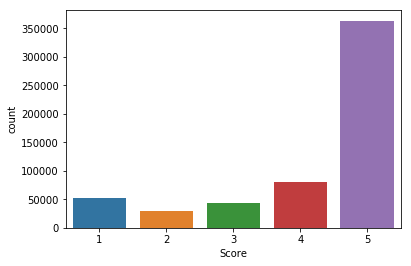

In [9]:
#count plot for Score
sns.countplot(x='Score',data=data)

In [9]:
# let's look at some of the reviews(summary) for Score 2
data[data['Score']==2]['Summary'].head(10)
# we observe that customers giving score as 2 have negative reviews

3                 Cough Medicine
16                    poor taste
67         Taste is not so good.
74               nothing special
110    Low Carb Angel Food Puffs
131                   Not for me
146       BROKEN BOTTLE BOTTOMS!
200               Altoids Smalls
212       Nearly killed the cats
224               Not a real tea
Name: Summary, dtype: object

In [10]:
# let's look at some of the reviews(summary) for Score 3
data[data['Score']==3]['Summary'].head(10)
# we observe that customers giving score as 3 are neutral

45                                        Hearty Oatmeal
47                                                 Mushy
49                                            Same stuff
53                                        not ass kickin
60                       Better price for this at Target
68     How much would you pay for a bag of chocolate ...
78                            Order only in cold weather
83                         Natural Balance Lamb and Rice
84                             INCREASED MY DOGS ITCHING
106                                        disappointing
Name: Summary, dtype: object

In [11]:
# let's look at some of the reviews for Score 4
data[data['Score']==4]['Summary'].head(10)
# we observe that customers giving score as 4 are happy with the product

2                                 "Delight" says it all
5                                            Nice Taffy
13                                    fresh and greasy!
27                          Great Bargain for the Price
32                         Best of the Instant Oatmeals
33                                         Good Instant
35                                           satisfying
38                        GOOD WAY TO START THE DAY....
48    Very good but next time I won't order the Vari...
52             You'll go nuts over Ass-Kickin' Peanuts.
Name: Summary, dtype: object

In [12]:
# let's look at some of the reviews for Score 5
data[data['Score']==5]['Summary'].head(10)
# we observe that customers giving score as 5 are ssatisfied with the product

0                                 Good Quality Dog Food
4                                           Great taffy
6         Great!  Just as good as the expensive brands!
7                                Wonderful, tasty taffy
8                                            Yay Barley
9                                      Healthy Dog Food
10                      The Best Hot Sauce in the World
11    My cats LOVE this "diet" food better than thei...
14                         Strawberry Twizzlers - Yummy
15             Lots of twizzlers, just what you expect.
Name: Summary, dtype: object

In [10]:
#we will perform sentimental analysis on positive and negative reviews
# removing neutral ones
data=data[data['Score']!=3]

In [11]:
# adding new column sentiments based on Score given by customer
data["Sentiment"] = data["Score"].apply(lambda score: "positive" if score > 3 else "negative")
#df["Usefulness"] = (df["HelpfulnessNumerator"]/df["HelpfulnessDenominator"]).apply(lambda n: "useful" if n > 0.8 else "useless")

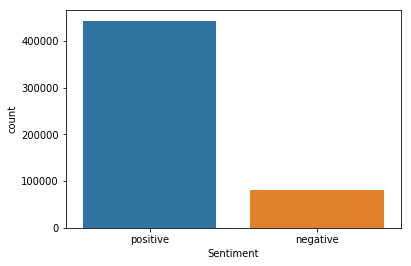

In [12]:
#Count plot of total positive and b=negative reviews
k=sns.countplot(x='Sentiment',data=data)

# Text Processing

In [13]:
#assigning new dimension to each word and work with word counts
#text processing
#importing 
import string
import re
string.punctuation
from nltk.corpus import stopwords

In [14]:
# creating cleanup function
# removing special character and trailing spaces
cleanup_re = re.compile('[^a-z]+')
def cleanup(sentence):
    sentence = sentence.lower()
    sentence = cleanup_re.sub(' ', sentence).strip()
    return sentence

In [15]:
data['Text_Clean']=data['Text'].apply(cleanup)

In [16]:
# we will apply the same cleanup on Summary
# first we need to remove Nan values from Summary Column
df=data.dropna(subset=['Summary'])
df['Summary_Clean']=df['Summary'].apply(cleanup)

C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [17]:
#looking at clean summary
df['Summary_Clean'][0]

'good quality dog food'

In [18]:
# Looking at Clean text
data['Text_Clean'][0]

'i have bought several of the vitality canned dog food products and have found them all to be of good quality the product looks more like a stew than a processed meat and it smells better my labrador is finicky and she appreciates this product better than most'

# Creating Wordcloud for the reviews given

In [19]:
#!pip install wordcloud
from wordcloud import WordCloud,STOPWORDS
stopwords = set(STOPWORDS)
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(data))
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title:
     fig.suptitle(title, fontsize=20)
     fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()

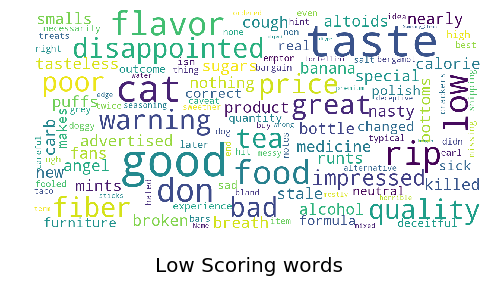

In [20]:
show_wordcloud(df[(df['Score']==1) | (df['Score']==2)]['Summary_Clean'], title="Low Scoring words")

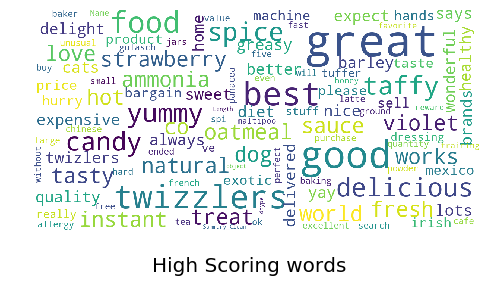

In [21]:
show_wordcloud(df[(df['Score']==4) | (df['Score']==5)]['Summary_Clean'], title="High Scoring words")

# Feature Extraction from Text
## Using TfIDF(Term Freq Inverse Doc Frequency)


In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import ngrams

In [23]:
tfidf_transformer = TfidfVectorizer(ngram_range=(1,2), stop_words='english')
reviews_tfidf = tfidf_transformer.fit_transform(data['Text_Clean'])

In [24]:
reviews_tfidf.shape

(525814, 3840528)

In [27]:
print(tfidf_transformer.get_feature_names()[100])

aaaaaaaaaaaa buy


In [ ]:
#print(reviews_tfidf.toarray())

In [28]:
X=reviews_tfidf
y= data['Sentiment']

# Split the Data Into Training and Testing Prior to Training

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

# Function to train our data


In [31]:
def model_fit(model):
    modelFit=model.fit(X_train, y_train)
    y_predict_test = model.predict(X_test)
    cm = confusion_matrix(y_test, y_predict_test)
    sns.heatmap(cm, annot=True)
    print("Accuracy:",metrics.accuracy_score(y_test, y_predict_test))
    
    w = tfidf_transformer.get_feature_names()
    coef = modelFit.coef_.tolist()[0]
    coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
    coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=False)
    
    print('')
    print('-Top 20 positive-')
    print(coeff_df.head(20).to_string(index=False))
    print('')
    print('-Top 20 negative-')      
    print(coeff_df.tail(30).to_string(index=False))
    return y_predict_test

# Aplying Naive Byes

Accuracy: 0.8488346661848749

-Top 20 positive-
Word  Coefficient
     br    -6.594892
  great    -7.150853
 coffee    -7.210164
   good    -7.226362
   like    -7.272002
    tea    -7.326792
   love    -7.357351
  br br    -7.455553
product    -7.493436
  taste    -7.505628
 flavor    -7.516762
   just    -7.533810
   food    -7.680300
   best    -7.736693
 amazon    -7.771790
 really    -7.808635
  price    -7.823794
    use    -7.921955
     ve    -7.935209
   time    -7.947087

-Top 20 negative-
Word  Coefficient
                   aaaaallll   -15.649048
aaaaahhhhhhhhhhhhhhhh angels   -15.649048
       aaaaahhhhhhhhhhhhhhhh   -15.649048
    aaaaaahhhhhyaaaaaa fired   -15.649048
          aaaaaahhhhhyaaaaaa   -15.649048
           aaaaaahhhhh leave   -15.649048
                 aaaaaahhhhh   -15.649048
       aaaaaaarrrrrggghhh br   -15.649048
          aaaaaaarrrrrggghhh   -15.649048
               aaaaaaaaagghh   -15.649048
               aaaaaaaaaaaaa   -15.649048
               

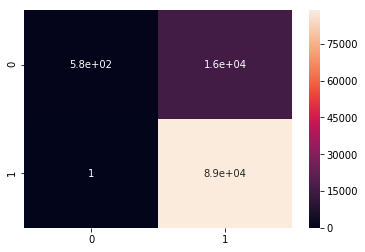

In [32]:
from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
prediction=model_fit(NB_classifier)

# Applying Logistic Regression

C:\Users\Kulbeer Singh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 0.945760391012048

-Top 20 positive-
      Word  Coefficient
     great    21.036027
      best    17.997579
 delicious    17.410540
   perfect    14.693455
     loves    13.936261
      love    13.076281
 excellent    12.995694
      good    11.728772
 wonderful    11.569809
  favorite    10.905715
      nice    10.868833
   amazing    10.090181
   awesome     9.559194
     happy     9.089360
   pleased     9.084099
      easy     8.889426
    highly     8.651454
     yummy     8.569536
      glad     8.535481
     tasty     8.434224

-Top 20 negative-
           Word  Coefficient
           yuck    -6.979353
    waste money    -7.010436
          nasty    -7.032859
         refund    -7.099395
     won buying    -7.142037
           poor    -7.229311
          waste    -7.318804
            rip    -7.356760
          gross    -7.589036
          sorry    -7.683861
          maybe    -7.869723
         hoping    -7.971569
      tasteless    -8.253568
          money    -8.29

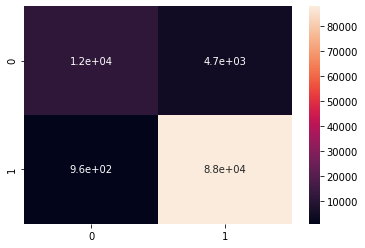

In [37]:
from sklearn.linear_model import LogisticRegression
start = timeit.timeit()
logmodel = LogisticRegression()
prediction=model_fit(logmodel)
end = timeit.timeit()
print(end - start)

# Visualization using bokeh

In [35]:
amazon_data['Time'] = pd.to_datetime(amazon_data['Time'], unit='s')

In [36]:
amazon_data['Helpfulness'] = amazon_data['HelpfulnessNumerator']/amazon_data['HelpfulnessDenominator']

In [37]:
amazon_data = amazon_data.drop(['HelpfulnessNumerator','HelpfulnessDenominator'], axis=1)

In [38]:
amazon_data["Helpfulness"] = amazon_data["Helpfulness"].fillna(0)

In [39]:
top_products = amazon_data['ProductId'].value_counts().head(20).rename_axis('Product_Id').reset_index(name='Total Reviews')

In [40]:
i1 = amazon_data.set_index('ProductId').index
i2 = top_products.set_index('Product_Id').index

In [41]:
top_products = pd.merge(top_products, 
                        amazon_data[i1.isin(i2)].groupby('ProductId')['Score'].mean().rename_axis('Product_Id').reset_index(name='Avg_score'),
                        on="Product_Id")

In [ ]:
top_products # these are top 20 reviewed products in our dataset

In [43]:
#count of top 20 reviewed products
p = figure(x_range=top_products['Product_Id'].tolist(),x_axis_label='Product Id',y_axis_label='Total Reviews' , plot_height=400, plot_width=700, title="Top Reviewed products",
           toolbar_location=None,y_range=(0, 1000))

p.vbar(x=top_products['Product_Id'].tolist(), top=top_products['Total Reviews'].tolist(), width=0.5)


p.xaxis.major_label_orientation = "vertical"


#p.xgrid.grid_line_color = None
p.y_range.start = 0

show(p)

In [44]:
top_users = amazon_data['UserId'].value_counts().head(20).rename_axis('UserId').reset_index(name='Total_Reviews')

In [45]:
i3 = top_users.set_index('UserId').index
i4 = amazon_data.set_index('UserId').index

In [46]:
top_users = pd.merge(top_users, 
                     amazon_data[i4.isin(i3)].groupby('UserId')['Helpfulness'].mean().rename_axis('UserId').reset_index(name='Avg_Helpfulness_percentage'), 
                     on="UserId")

In [47]:
top_users['Avg_Helpfulness_percentage'] = 100 * top_users['Avg_Helpfulness_percentage'] 

In [ ]:
top_users.head()

In [49]:
#count of top 20 users 
p = figure(x_range=top_users['UserId'].tolist(), plot_height=400, plot_width=700,x_axis_label='User Id',y_axis_label='Total Reviews' ,title="Users with Maximum numbers of reviews given",
           toolbar_location=None,y_range=(0, 500))

p.vbar(x=top_users['UserId'].tolist(), top=top_users['Total_Reviews'].tolist(), width=0.5)
p.line(top_users['UserId'].tolist(),top_users['Avg_Helpfulness_percentage'].tolist(),color='red',line_width=1)

p.xaxis.major_label_orientation = "vertical"


#p.xgrid.grid_line_color = None
p.y_range.start = 0

show(p)